In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
import gpnn
import pyNNGP
import ipywidgets as widgets

from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style(context='notebook', fscale=1.5, figsize=(8.0, 8.0/1.618))
import tensorflow as tf
mnist_keras = tf.keras.datasets.mnist
(x_train_full, y_train_full),(x_test_full, y_test_full) = mnist_keras.load_data()
x_train_full, x_test_full = x_train_full / 255.0, x_test_full / 255.0

im_nx, im_ny = x_train_full.shape[1:3]

def convert_to_one_hot(a, num_labels=10):
    b = np.zeros((a.shape[0], num_labels))
    b[np.arange(a.shape[0]), a] = 1
    return b

def get_gp_data_subset(n_train=500, n_test=500):
    x_flat = np.row_stack((x_train_full[0:n_train, ...].reshape((n_train, im_nx*im_ny)),
                           x_test_full[0:n_test, ...].reshape(n_test, im_nx*im_ny)))
    return x_flat

n_train = 500
n_test = 500

x_gp = get_gp_data_subset()
x = gpnn.util.normalize(x_gp)
x /= 28.

x_train = x[0:n_train]
x_test = x[n_train:]
labels_train = convert_to_one_hot(y_train_full[0:n_train]) - 0.1
labels_test = convert_to_one_hot(y_test_full[0:n_test]) - 0.1

nNeighbors = 6
noise = 0.25
sigmaSqW = 1.79
sigmaSqB = 0.83
L = 10

covModel = pyNNGP.NNKernel(
    L=L, sigmaSqW=sigmaSqW, sigmaSqB=sigmaSqB
)
    
noiseModel = pyNNGP.ConstHomogeneousNoiseModel(noise)

distFunc = pyNNGP.DotProduct()

compFunc = pyNNGP.Greater()
# fit the model
n4gp = pyNNGP.SeqNNGP(
    labels_train, x_train,
    nNeighbors=nNeighbors,
    covModel=covModel,
    distFunc=distFunc,
    compFunc=compFunc,
    noiseModel=noiseModel,
    normalize=True
)

In [2]:
labels_train.shape

(500, 10)

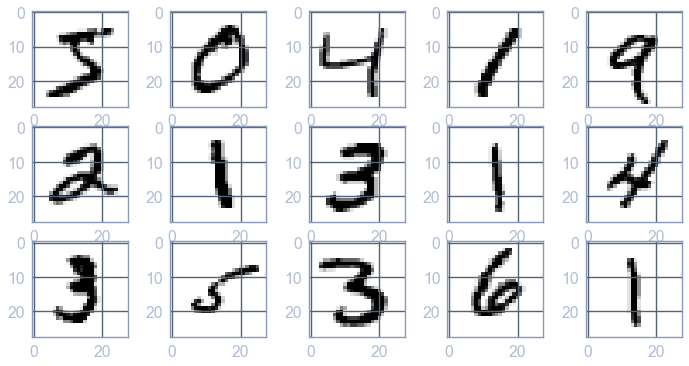

In [3]:
fig = plt.figure(figsize=(12,6))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(x_train_full[i,:,:], cmap=plt.cm.gray_r)

In [4]:
wstar_sample = n4gp.predict_targets(x_test.T, labels_train, 40, 50)

In [5]:
wstar_sample.shape

(10, 500)

In [6]:
wstar_sample[:,0]

array([-0.08000253, -0.00365482,  0.01402018,  0.06642103,  0.03573256,
       -0.00231223, -0.01141435, -0.01532159, -0.09219532,  0.00841315])

In [9]:
print("Test accuracy: {:5.4f}".format(np.sum(np.equal(np.argmax(wstar_sample.T, 1), 
                                                      np.argmax(labels_test, 1))
                                            ) / float(n_test)))

Test accuracy: 0.0920
